In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.utils import functions, path
from spectrome.brain import Brain


from spectrome.forward import ntf_local_stimulus as nt_stim
from spectrome.forward import ntf_local as nt_nostim
from spectrome.forward import ntf_local_stimulus as nt_stim

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

from scipy.io import savemat
import pickle as pkl

In [2]:
##For EEG
##modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))


In [3]:
# All regions
df=pd.read_excel('../ListROIs_DK.xlsx')
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

all_regions=[r.replace(' L', '-lh').replace(' R', '-rh') for r in all_regions[:68]]

In [4]:
## Mean parameter(MI/RS-1) value for each region across 19 subjects
mi_rs_meg_gii_lists={}
mi_rs_meg_gei_lists={}
mi_rs_meg_taue_lists = {}

for idx in range(0,68):
    gei_session_values = []
    gii_session_values = []
    taue_session_values = []
    for session in range(1, 5):  
        #gei, at 0
        mean_gei = ((np.mean(x_mi_all[session][idx, 0, :]))/(np.mean(x_rest_all[session][idx, 0, :])))-1 
        #gii, at 1
        mean_gii = ((np.mean(x_mi_all[session][idx, 1, :]))/(np.mean(x_rest_all[session][idx, 1, :])))-1 
        #taue, at 2
        mean_taue = ((np.mean(x_mi_all[session][idx, 2, :]))/(np.mean(x_rest_all[session][idx, 2, :])))-1 
        gei_session_values.append(mean_gei)
        gii_session_values.append(mean_gii) 
        taue_session_values.append(mean_taue)
        
    mi_rs_meg_gei_lists[f"ROI_{idx}"]  = gei_session_values
    mi_rs_meg_gii_lists[f"ROI_{idx}"]  = gii_session_values
    mi_rs_meg_taue_lists[f"ROI_{idx}"]  = taue_session_values

gei_values = np.array([mi_rs_meg_gei_lists[f'ROI_{i}'] for i in range(68)])
gii_values = np.array([mi_rs_meg_gii_lists[f'ROI_{i}'] for i in range(68)])
taue_values = np.array([mi_rs_meg_taue_lists[f'ROI_{i}'] for i in range(68)])

regions = [r.replace(' L', '-lh').replace(' R', '-rh') for r in all_regions[:68]]
sessions = ["S1", "S2", "S3", "S4"]

##each paremeters having their own dataframe
df_gei = pd.DataFrame(gei_values, index=regions, columns=sessions)
df_gii = pd.DataFrame(gii_values, index=regions, columns=sessions)
df_taue = pd.DataFrame(taue_values, index=regions, columns=sessions)

## Independent EEG data

In [5]:
##validation modeled data
x_mi_ind={}
x_rest_ind={}

num=1
x_mi_ind[num]=np.zeros((68, 10, 26))
x_rest_ind[num]=np.zeros((68, 10, 26))

for i in range(26):
    mi_fname = f'../bci_results_apd/bci_results/validation/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
    with open(mi_fname, 'rb') as f:
        x_mi_ind[num][:,:,i]=np.array(pkl.load(f))
    
    rest_fname = f'../bci_results_apd/bci_results/validation/rest_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
    with open(rest_fname, 'rb') as f:
        x_rest_ind[num][:,:,i]=np.array(pkl.load(f))

In [6]:
## Mean parameter(MI/RS-1) value for each region across 19 subjects (single session)
mi_rs_gei_ind = {}
mi_rs_gii_ind = {}
mi_rs_taue_ind = {}

for idx in range(68):
    mean_gei = (np.mean(x_mi_ind[1][idx, 0, :])/np.mean(x_rest_all[1][idx, 0, :])) - 1
    mean_gii = (np.mean(x_mi_ind[1][idx, 1, :])/np.mean(x_rest_all[1][idx, 1, :])) - 1
    mean_taue = (np.mean(x_mi_ind[1][idx, 2, :])/np.mean(x_rest_all[1][idx, 2, :])) - 1

    mi_rs_gei_ind[f"ROI_{idx}"] = mean_gei
    mi_rs_gii_ind[f"ROI_{idx}"] = mean_gii
    mi_rs_taue_ind[f"ROI_{idx}"] = mean_taue

#to numpy arrays
gei_values = np.array([mi_rs_gei_ind[f'ROI_{i}'] for i in range(68)])
gii_values = np.array([mi_rs_gii_ind[f'ROI_{i}'] for i in range(68)])
taue_values = np.array([mi_rs_taue_ind[f'ROI_{i}'] for i in range(68)])

#region names
regions = [r.replace(' L', '-lh').replace(' R', '-rh') for r in all_regions[:68]]

df_gei_ind = pd.DataFrame(gei_values, index=regions, columns=["MI/RS-1"])
df_gii_ind = pd.DataFrame(gii_values, index=regions, columns=["MI/RS-1"])
df_taue_ind = pd.DataFrame(taue_values, index=regions, columns=["MI/RS-1"])


In [7]:
df_gii_ind

MI/RS-1
bankssts-lh                 0.276241
bankssts-rh                 0.024886
caudalanteriorcingulate-lh  0.731754
caudalanteriorcingulate-rh  0.656551
caudalmiddlefrontal-lh      1.213120
...                              ...
supramarginal-rh            0.818504
temporalpole-lh             1.180036
temporalpole-rh             0.527510
transversetemporal-lh       0.201834
transversetemporal-rh       0.140818

[68 rows x 1 columns]

## Significant (pFDR<0.05) regions for MI vs RS

In [8]:
# EEG
#sess-4
#g_ei
gei_eeg_sess4_regions = ['cuneus-lh', 'cuneus-rh', 'inferiorparietal-lh', 'lateraloccipital-lh', 'precentral-lh']
#g_ii
gii_eeg_sess4_regions =['cuneus-lh', 'cuneus-rh', 'isthmuscingulate-lh', 'lingual-lh', 'parahippocampal-rh']
#tau_e
taue_eeg_sess4_regions =['supramarginal-rh']

#sess-2
#tau_e
taue_eeg_sess2_regions=['cuneus-lh']


#### Significant(pFDR<0.05)regions for the independent data

In [9]:
#Independent EEG data
gii_eeg_ind_regions=['bankssts-lh', 'caudalanteriorcingulate-lh', 'caudalanteriorcingulate-rh', 'caudalmiddlefrontal-lh', 'caudalmiddlefrontal-rh', 'cuneus-rh', 
                     'entorhinal-lh', 'frontalpole-lh', 'frontalpole-rh', 'insula-lh', 'medialorbitofrontal-lh', 'paracentral-rh', 'parahippocampal-rh', 
                     'parsopercularis-rh', 'parstriangularis-lh', 'pericalcarine-lh', 'posteriorcingulate-lh', 'posteriorcingulate-rh', 'precuneus-lh', 'precuneus-rh', 
                     'rostralanteriorcingulate-lh', 'rostralanteriorcingulate-rh', 'rostralmiddlefrontal-lh', 'superiorfrontal-rh', 'superiorparietal-rh', 'temporalpole-lh', 'temporalpole-rh']


taue_eeg_ind_regions=['lateralorbitofrontal-lh', 'lateralorbitofrontal-rh', 'medialorbitofrontal-lh', 'medialorbitofrontal-rh', 'rostralanteriorcingulate-rh']

## Brain plots 

In [10]:
'''
Code: To plot various brain region from DK atlas
'''
import xarray as xr
import mne
import matplotlib.pyplot as plt
from mne.viz import plot_brain_colorbar
from mne.viz import Brain
from mne.datasets import fetch_fsaverage
import os.path as op
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib import colormaps as cmaps
import numpy as np

# pip install netCDF4 h5netcdf
# !pip install pyvistaqt ipywidgets

In [11]:
data_xr = xr.open_dataarray("individual_psd_reordered_matlab.nc")
psd = data_xr.values
regions = data_xr["regionx"].values

In [12]:
regions_mne = []
count = 0

for i in range(len(regions)):
    if regions[i][0:2] == 'LH':
        regionname = regions[i][2:]
        regions_mne.append(regionname + '-lh')

    if regions[i][0:2] == 'RH':
        regionname = regions[i][2:]
        regions_mne.append(regionname + '-rh')


In [13]:
# Fetch fsaverage dataset
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# Load fsaverage subject details
subject = "fsaverage"
trans = "fsaverage"  # Built-in fsaverage transformation in MNE
src_fname = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")

# Read source spaces
src = mne.read_source_spaces(src_fname)

# Load labels from the fsaverage atlas
labels = mne.read_labels_from_annot(subject, parc="aparc", subjects_dir=subjects_dir)

0 files missing from root.txt in /Users/apurbadebnath/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/apurbadebnath/mne_data/MNE-fsaverage-data/fsaverage
    Reading a source space...


    [done]
    Reading a source space...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 35 labels from /Users/apurbadebnath/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/apurbadebnath/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


Using pyvistaqt 3d backend.


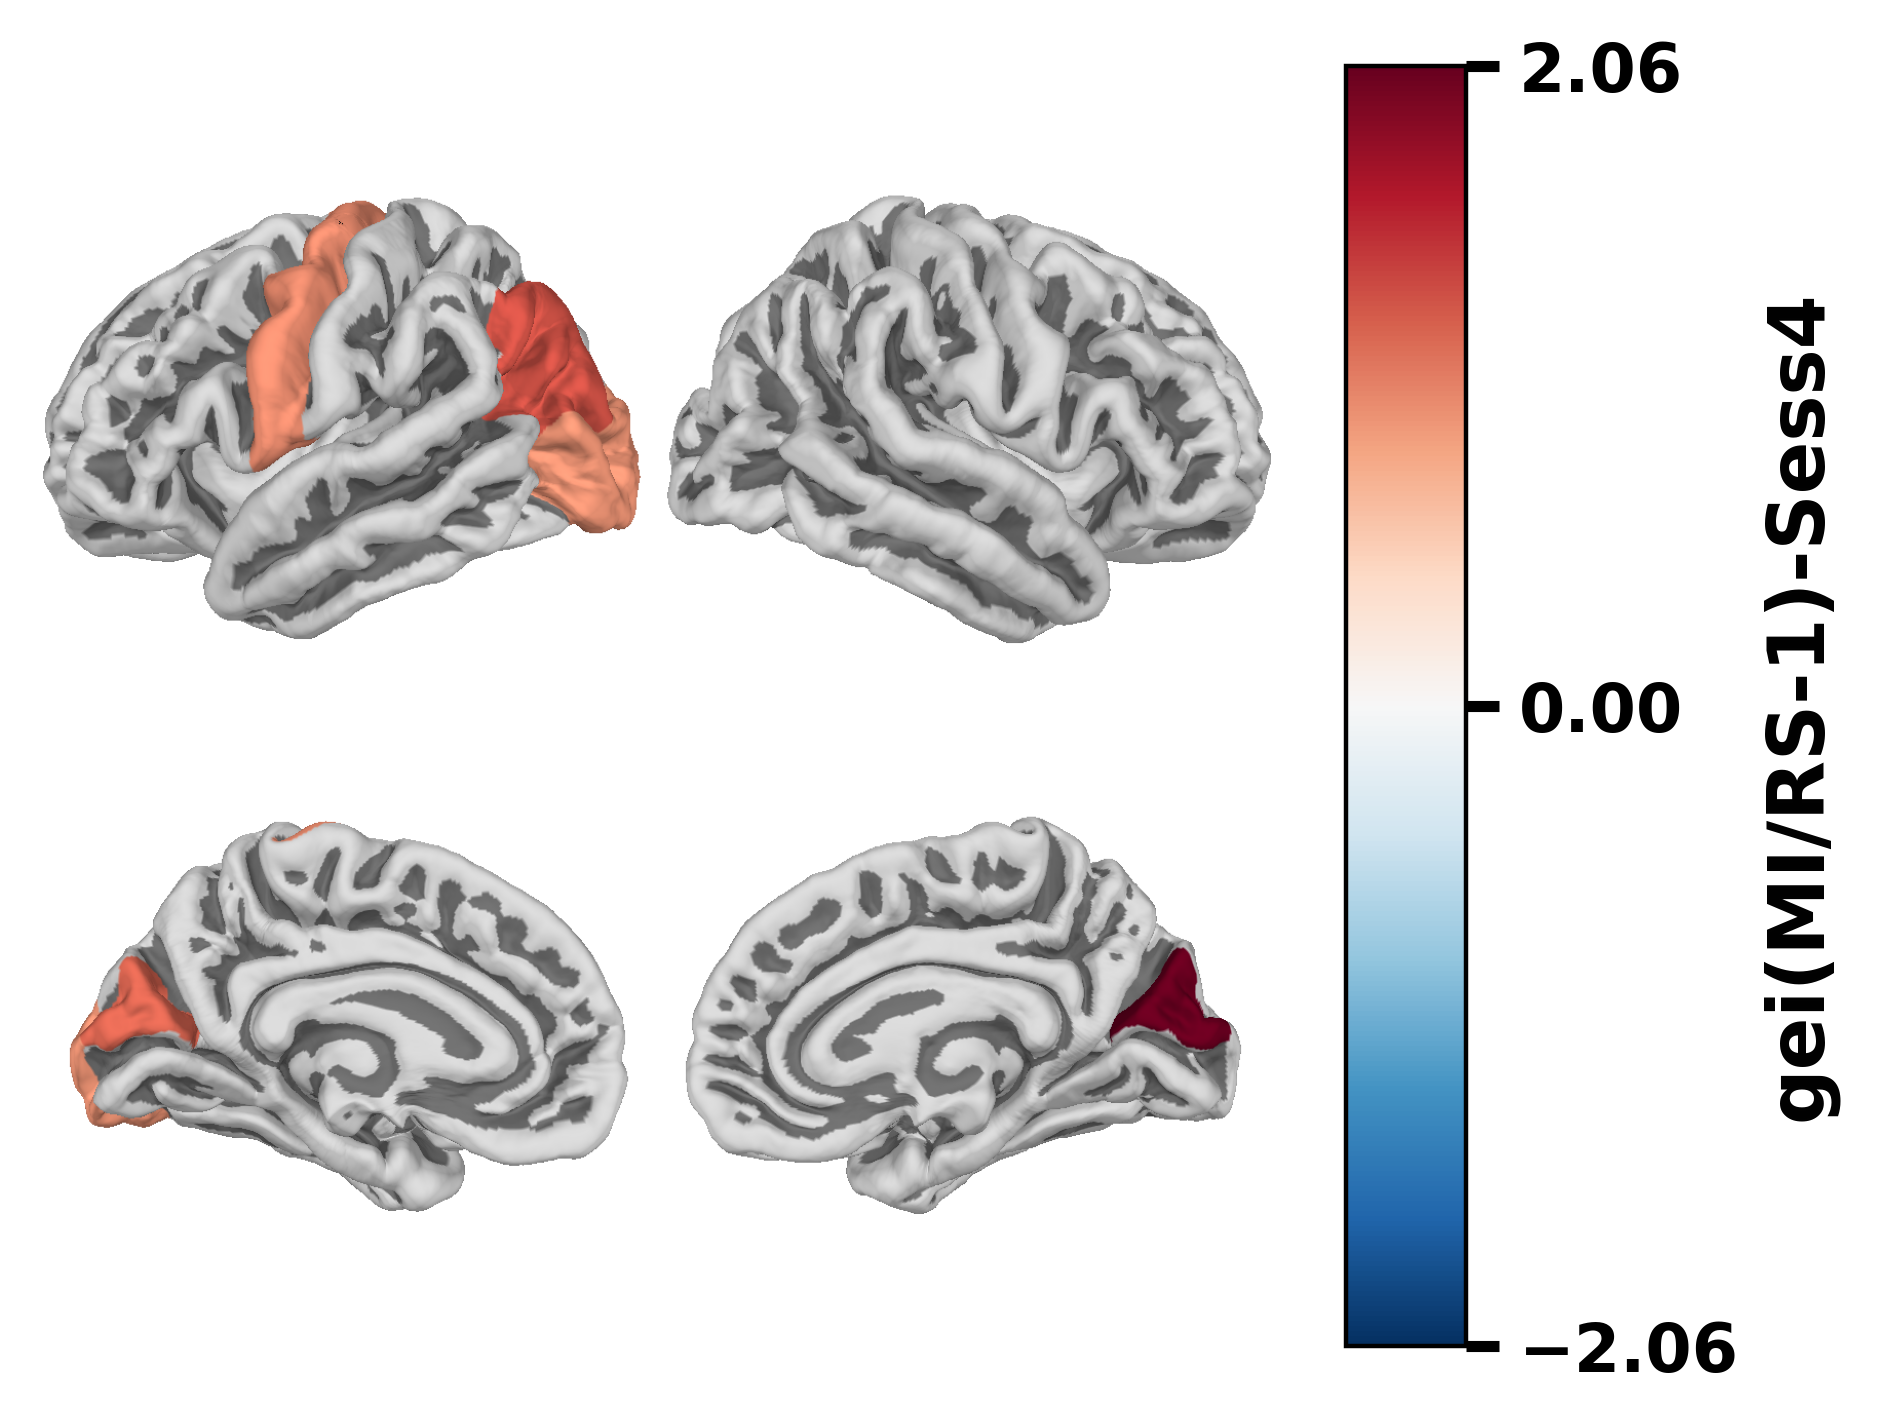

In [ ]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##gei
max_val = df_gei[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_gei[['S1', 'S2', 'S3', 'S4']].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_gei.index), list(df_gei['S4'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gei['S3'])), np.max(list(df_gei['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)

for label in labels:
    if label.name in gei_eeg_sess4_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 

# for label in labels:
#     if label.name in taue_meg_sess1_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_gei_eeg_sess4.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_gei_eeg_sess4.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("gei(MI/RS-1)-Sess4", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("taue(MI/RS-1)-Sess4")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/eeg_gei_mi_rs_sess4_brain.png", dpi=300)
plt.show()


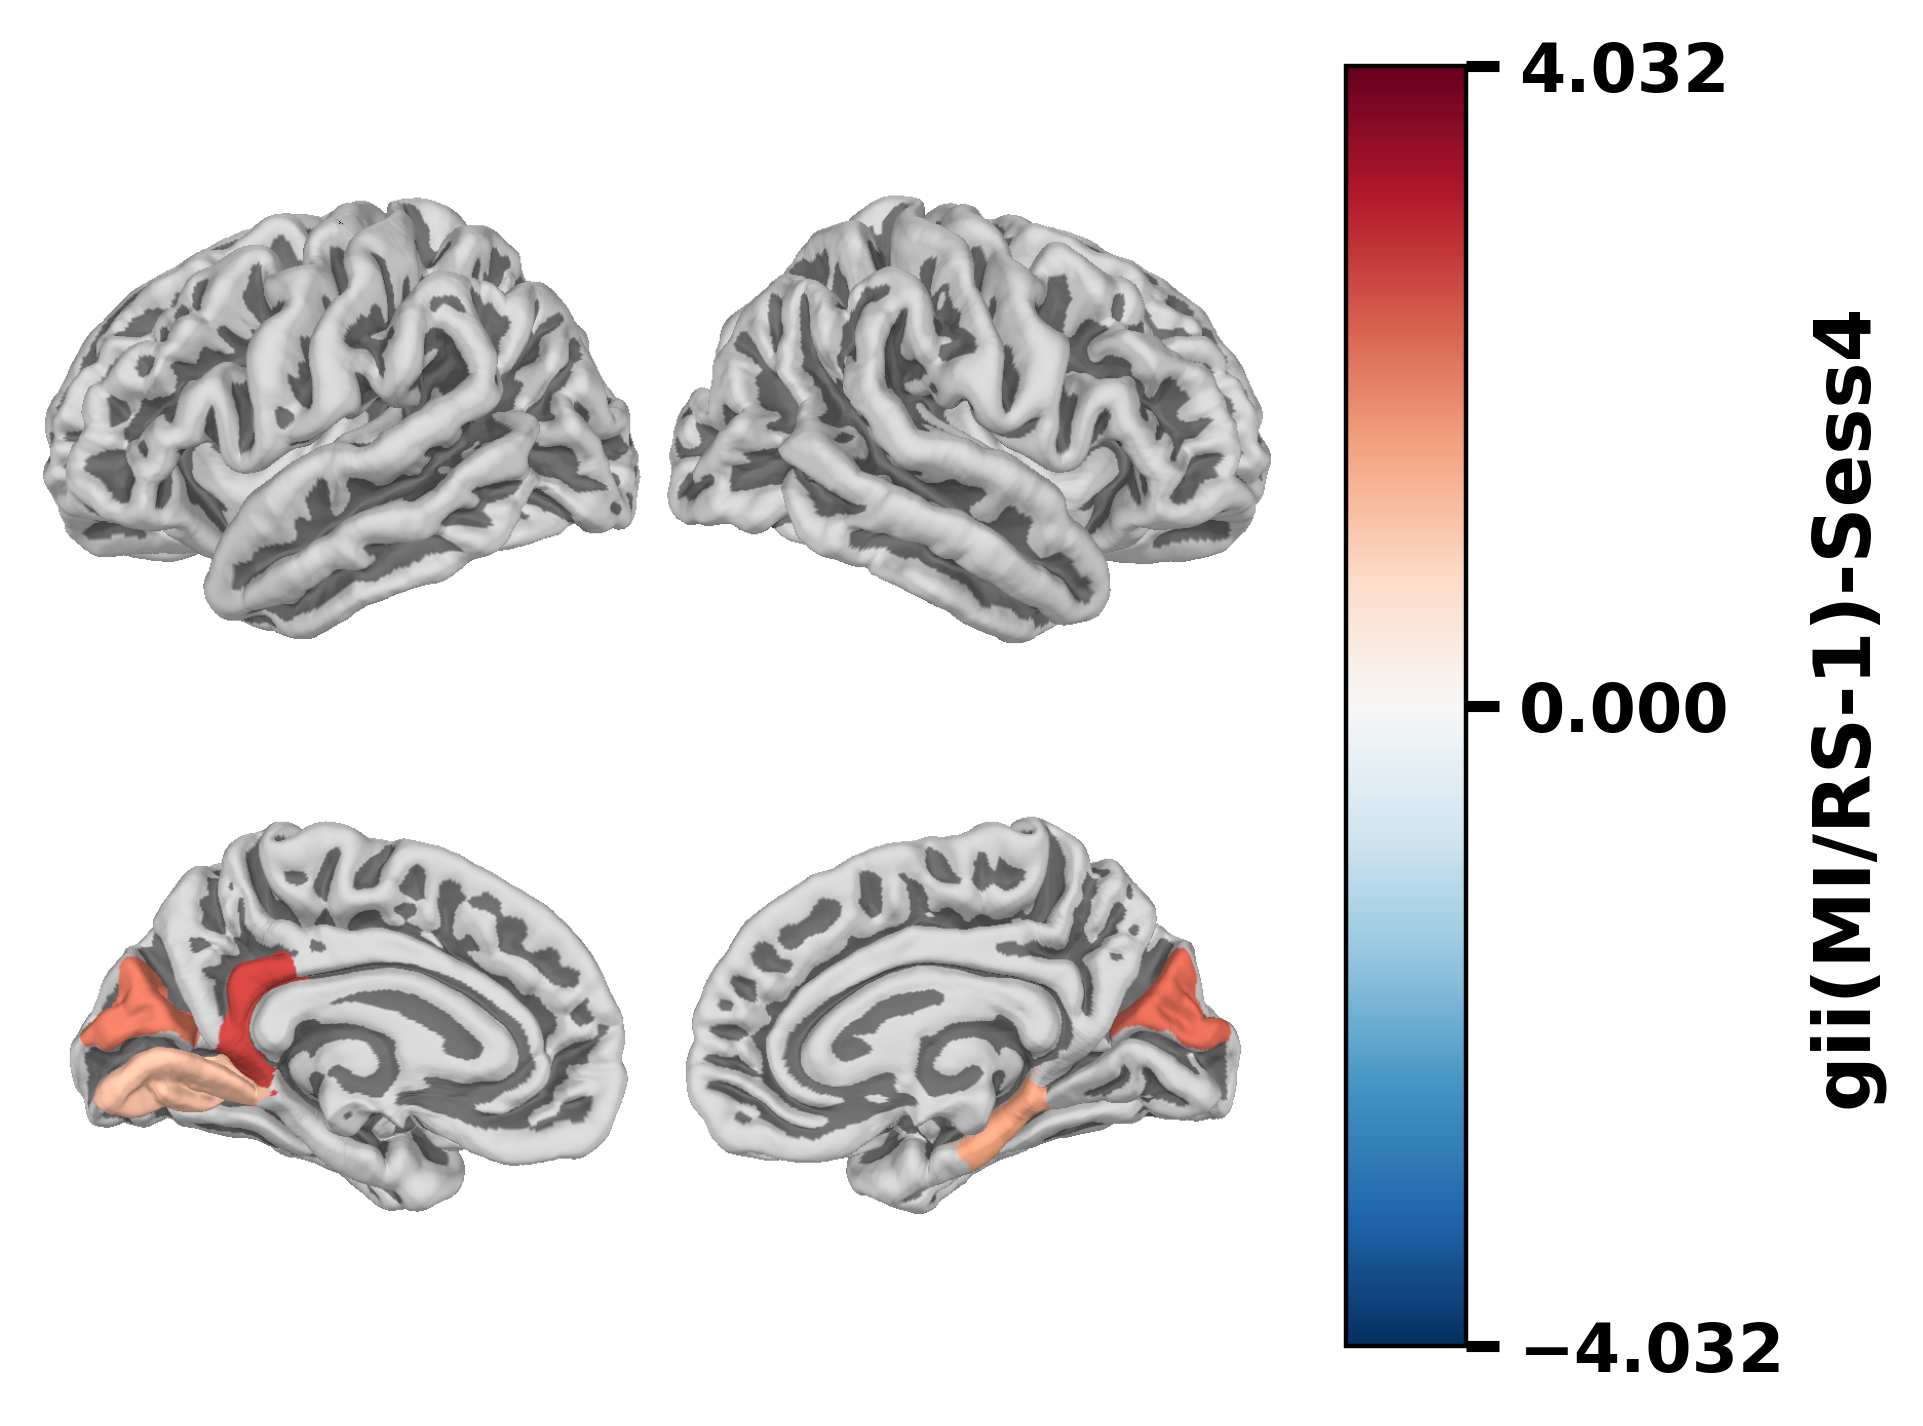

In [15]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##gei
max_val = df_gii[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_gii[['S1', 'S2', 'S3', 'S4']].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_gii.index), list(df_gii['S4'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gei['S3'])), np.max(list(df_gei['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)

for label in labels:
    if label.name in gii_eeg_sess4_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 

# for label in labels:
#     if label.name in taue_meg_sess1_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_gii_eeg_sess4.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_gii_eeg_sess4.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("gii(MI/RS-1)-Sess4", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("taue(MI/RS-1)-Sess4")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/eeg_gii_mi_rs_sess4_brain.png", dpi=300)
plt.show()


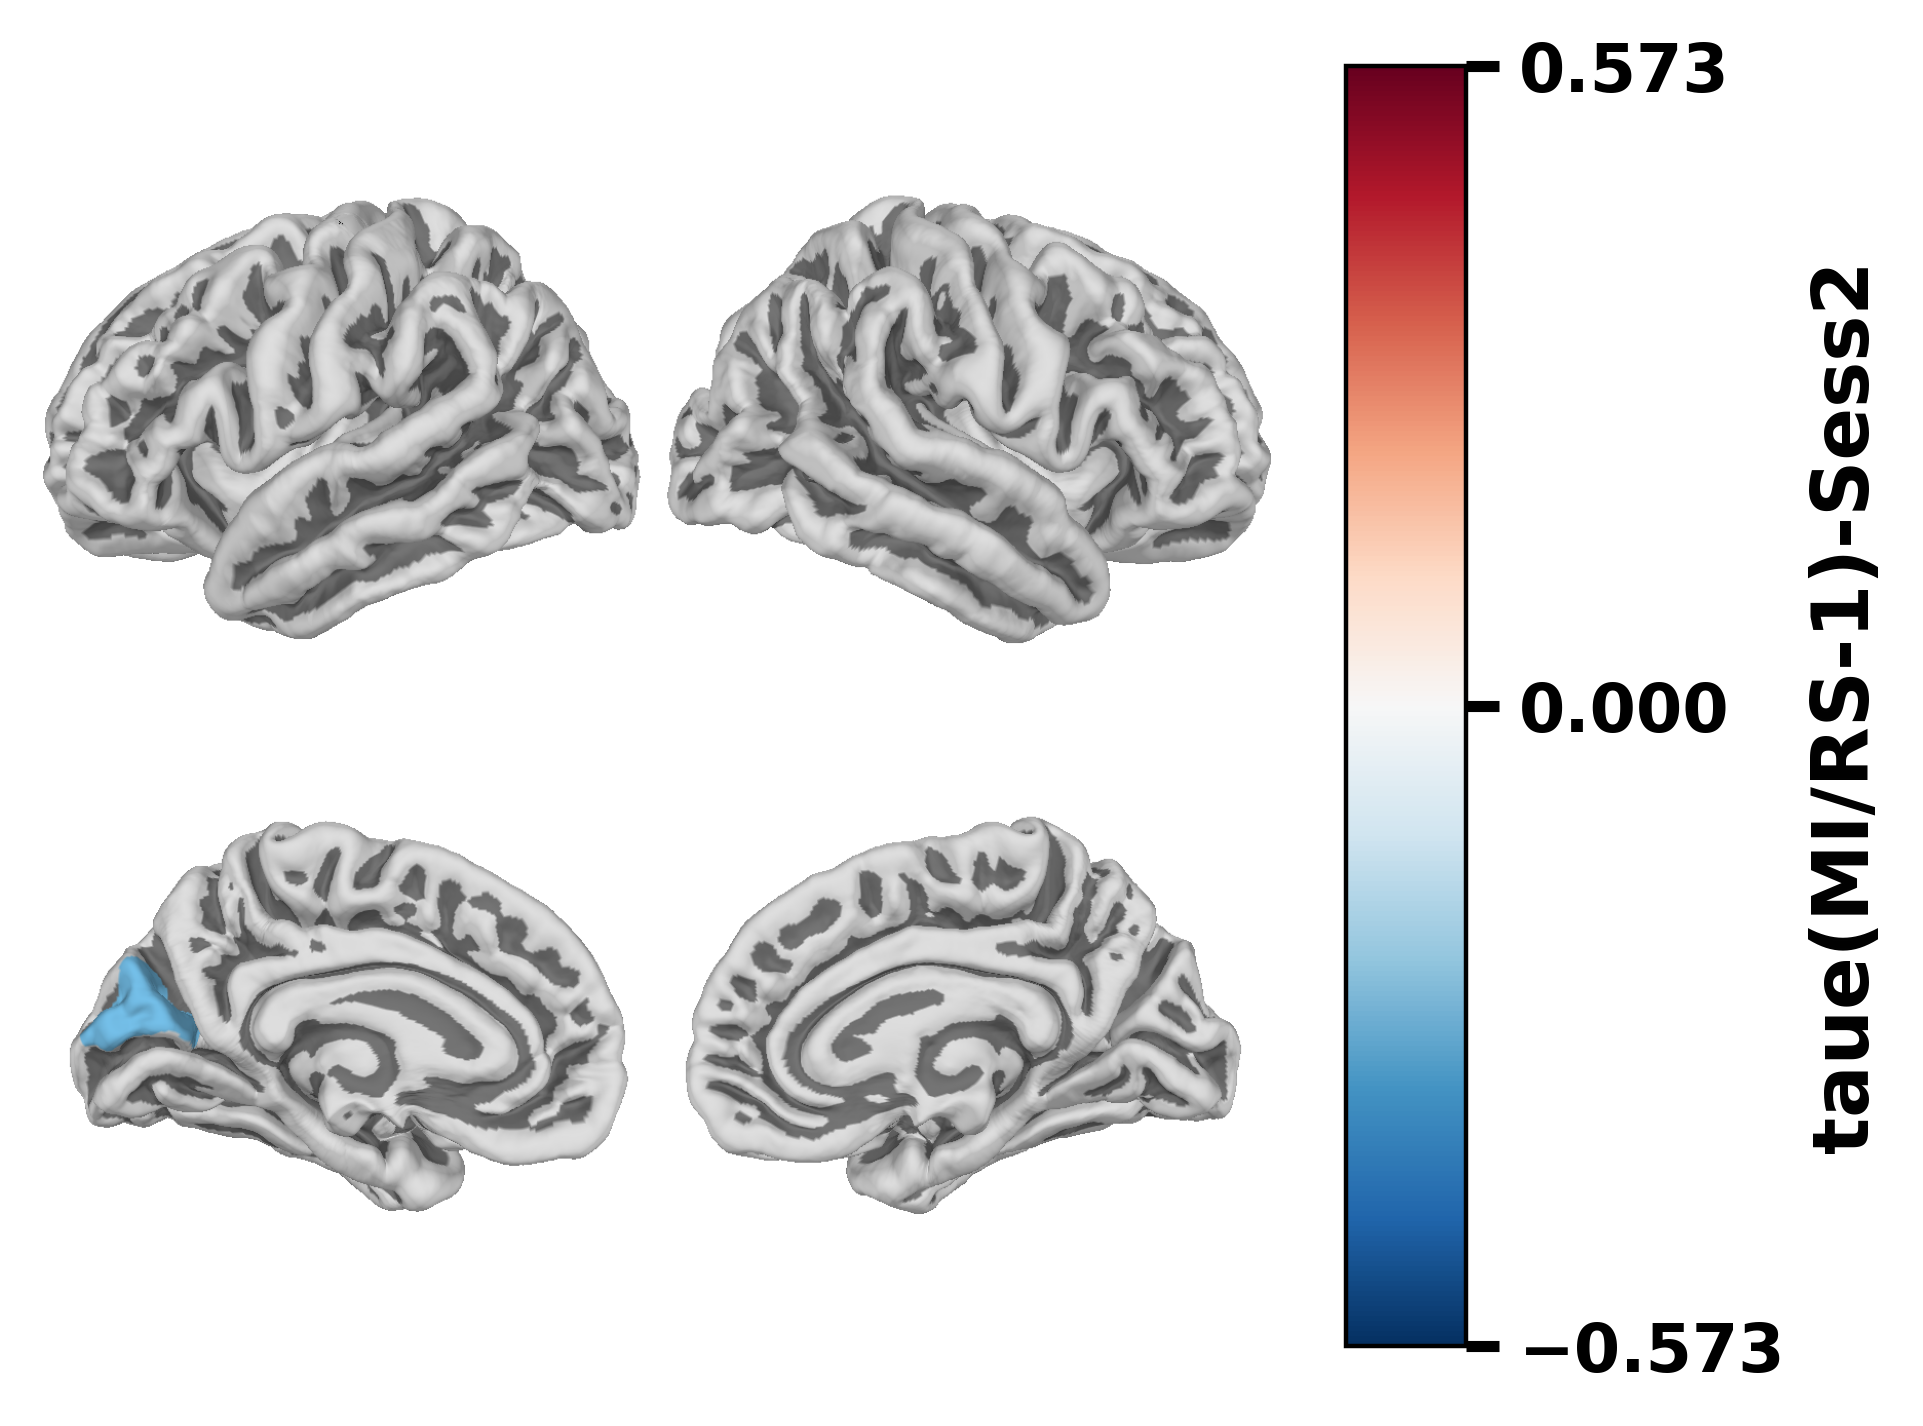

In [17]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##taue
max_val = df_taue[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_taue[['S1', 'S2', 'S3', 'S4']].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_taue.index), list(df_taue['S2'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gei['S3'])), np.max(list(df_gei['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)

for label in labels:
    if label.name in taue_eeg_sess2_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 

# for label in labels:
#     if label.name in taue_meg_sess1_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_taue_eeg_sess2.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_taue_eeg_sess2.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("taue(MI/RS-1)-Sess2", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("taue(MI/RS-1)-Sess4")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/eeg_taue_mi_rs_sess2_brain.png", dpi=300)
plt.show()


#### Brain plot for indepedent data

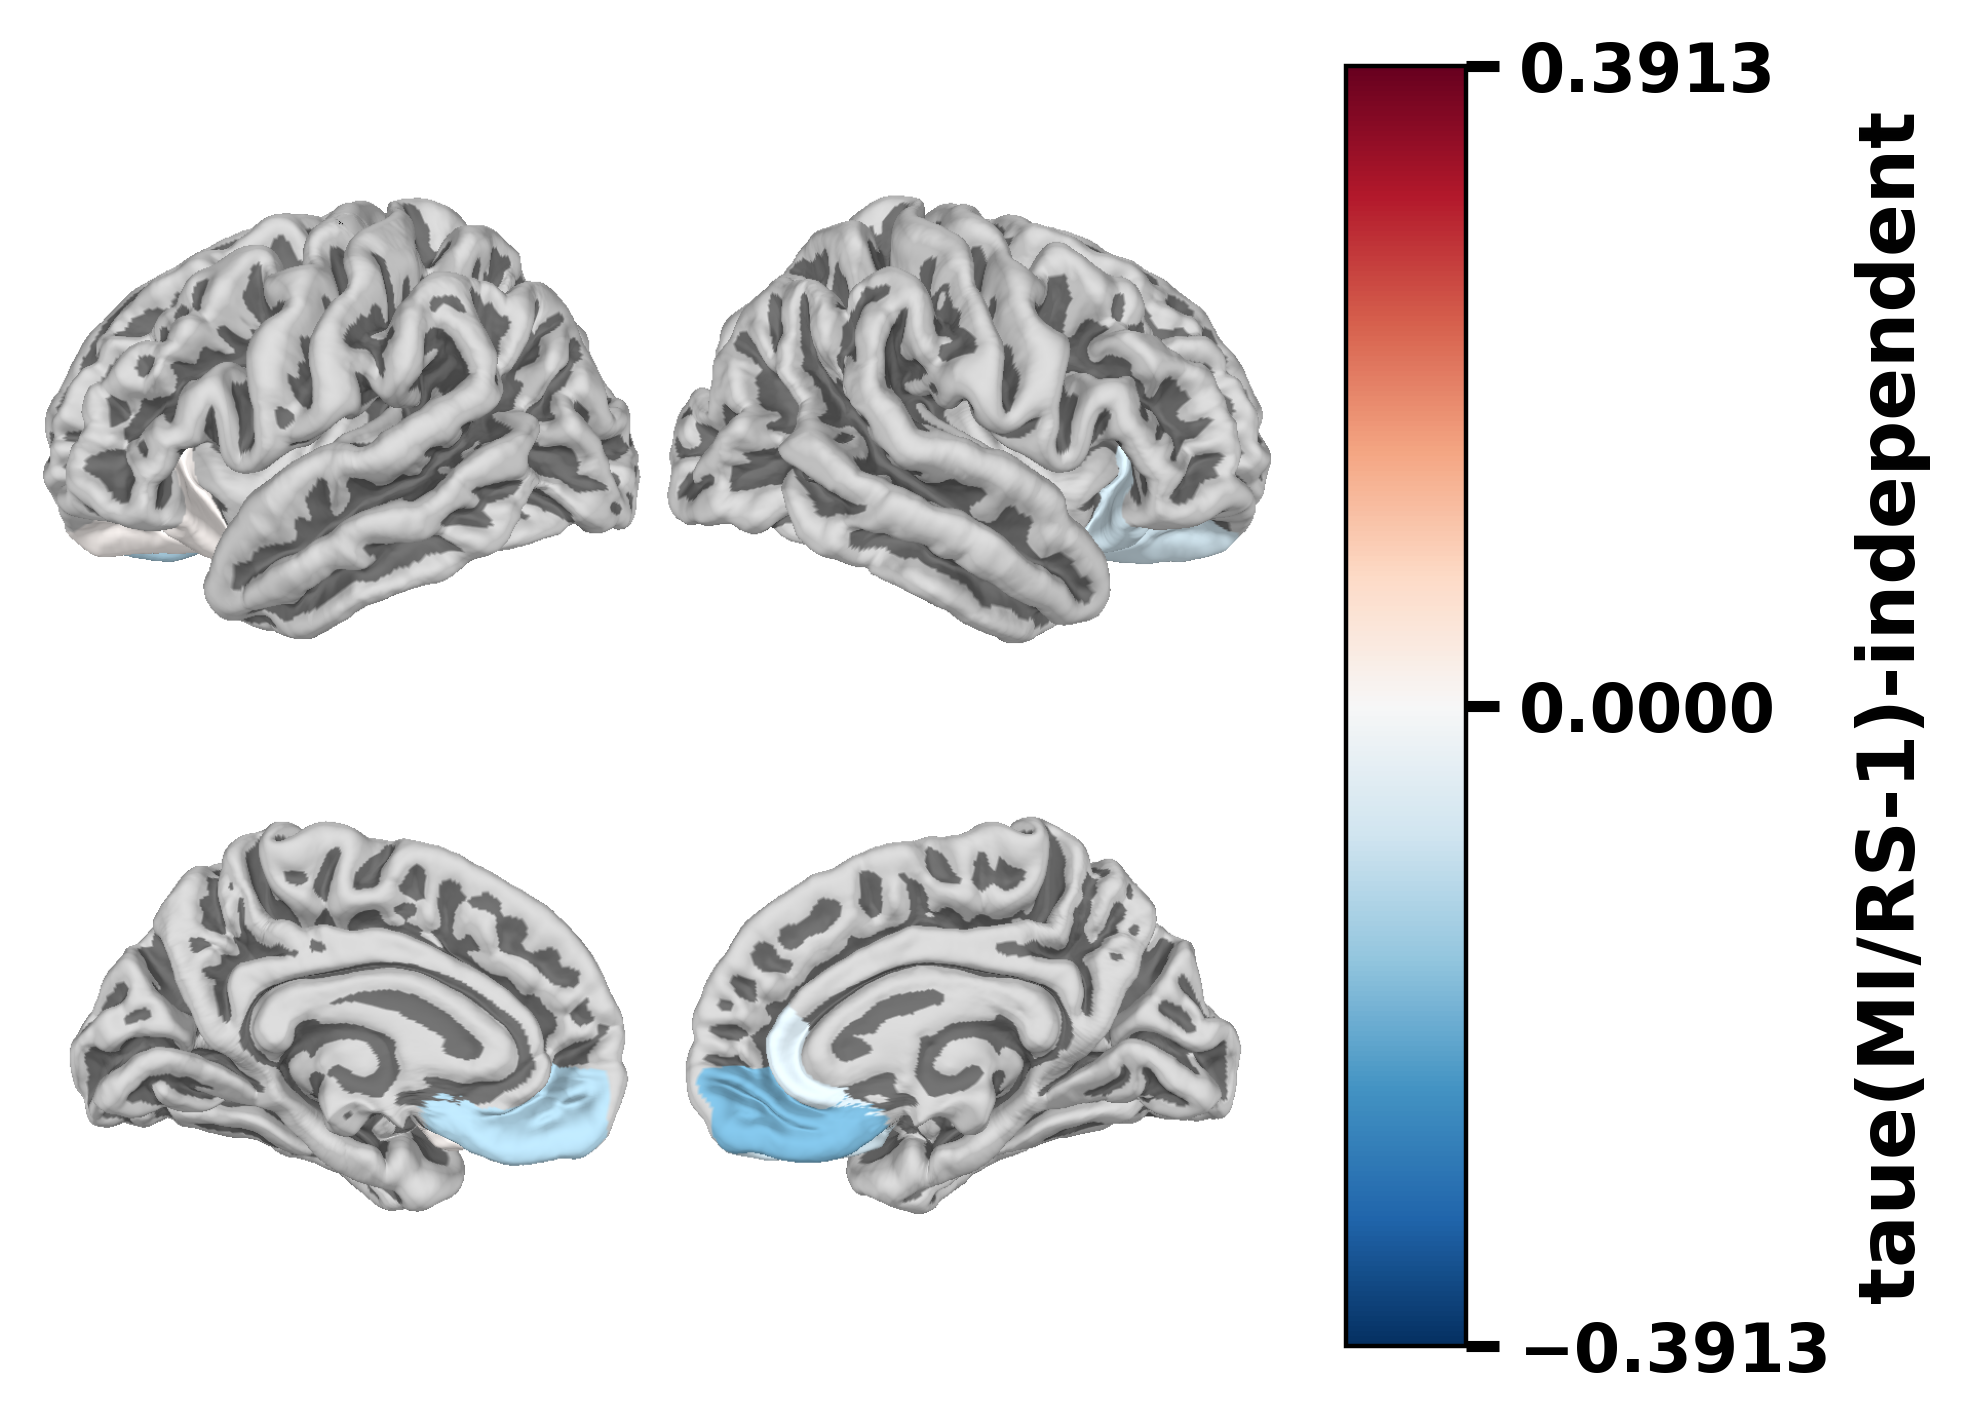

In [21]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##taue
max_val = df_taue_ind['MI/RS-1'].to_numpy().max()
min_val = df_taue_ind['MI/RS-1'].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_taue_ind.index), list(df_taue_ind['MI/RS-1'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gei['S3'])), np.max(list(df_gei['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)

for label in labels:
    if label.name in taue_eeg_ind_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 

# for label in labels:
#     if label.name in taue_meg_sess1_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_taue_ind.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_taue_ind.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("taue(MI/RS-1)-independent", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("taue(MI/RS-1)-Sess4")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/independent_taue_brain.png", dpi=300)
plt.show()


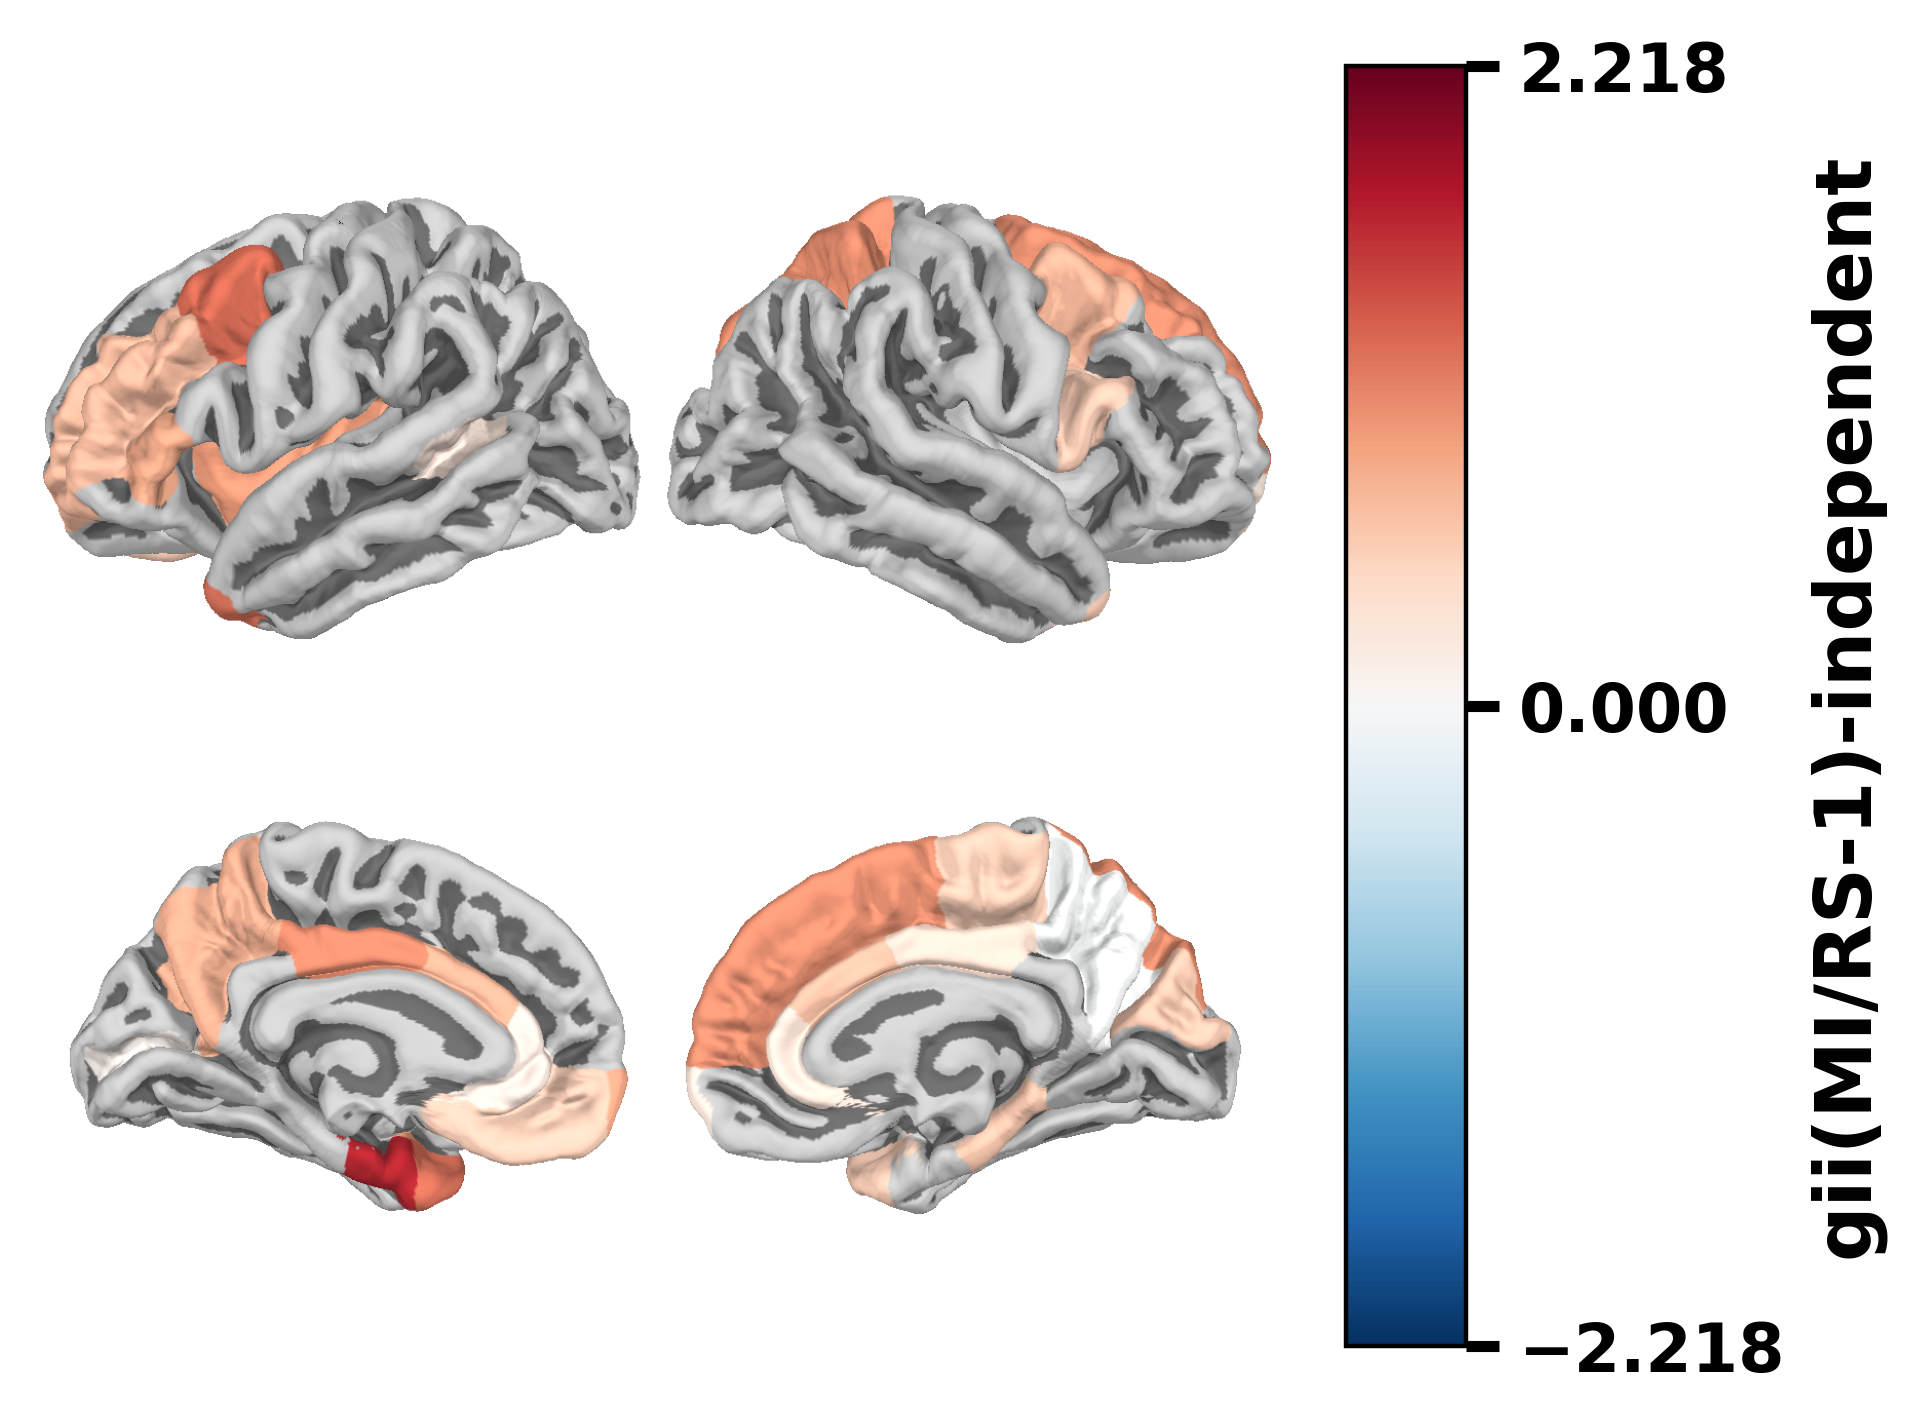

In [22]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##gii
max_val = df_gii_ind['MI/RS-1'].to_numpy().max()
min_val = df_gii_ind['MI/RS-1'].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_gii_ind.index), list(df_gii_ind['MI/RS-1'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gei['S3'])), np.max(list(df_gei['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)

for label in labels:
    if label.name in gii_eeg_ind_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 

# for label in labels:
#     if label.name in taue_meg_sess1_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_gii_ind.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_gii_ind.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("gii(MI/RS-1)-independent", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("taue(MI/RS-1)-Sess4")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/independent_gii_brain.png", dpi=300)
plt.show()
